# Домашнее задание 10

(прислать до 02:00 21.04.2020)

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне в Piazza через Private Post.
Файл с Вашим решением должен называться ```Surname_HW#```, где вместо ```Surname``` Вы пишите свою фамилию латиницей, а вместо ```#``` - номер домашнего задания. 
Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1 (13 pts)

- (5 pts) Приведите следующую задачу к виду, который допускает применение ADMM, и получите решения всех вспомогательных задач минимизации

$$
\min_x \frac12 \|Ax - b\|_2^2 + \lambda \|x\|_1,
$$

где $A \in \mathbb{R}^{m \times n}$ и $m > n$.

- (5 pts) Сравните скорость работы ADMM для получившейся задачи и метода FISTA, которым решается задача в исходной форме.
Простройте график зависимости скорости работы методов от размерности задачи, то есть от размерности целевой переменной.
- (3 pts) Также сравните точность, с которой решаются задачи для различных $n$.

Перепишем задачу в следующем виде:

$$
\min_x \frac{1}{2} \|Ax-b\|_2^2 + \lambda\|z\|_1\
$$

$$s.t.~z = x$$

Модифицированный лагранжиан:

$L(x, z, \mu) = \frac{1}{2} \|Ax-b\|_2^2 + \lambda\|z\|_1+\mu^T(x-z)+\frac{\rho}{2} \|x-z\|_2^2$

$\begin{equation*}
 \begin{cases}
   x^{k+1} = \arg\min_x L_{\rho}(x, z^k, \mu^k),\\
   z^{k+1} = \arg\min_z L_{\rho}(x^{k+1}, z, \mu^k),\\
   \mu^{k+1} = \mu^k + \rho(x^{k+1} - z^{k+1}).
 \end{cases}
\end{equation*}$

 $\frac{\partial L}{\partial x} = A^TAx - A^Tb+ \mu + \rho I(x-z) = 0 \Leftrightarrow x = (A^TA+\rho I)^{-1}(A^Tb - \mu) \Rightarrow x^{k+1} = (A^TA+\rho I)^{-1}(A^Tb - \mu^k+\rho z^k)$
 
 ${\partial L_z} = \lambda \partial(\|z\|_1) - \mu -\rho (x-z) \ni 0 \Rightarrow z^{k+1} = S_{\frac\lambda\rho}(x^{k+1} + \rho \mu^k),$ где $S_{\frac\lambda\rho}(x)_i = \begin{equation*}
 \begin{cases}
 x_i - \frac\lambda\rho, & x>\frac\lambda\rho,\\
 0, & -\frac\lambda\rho \leq x \geq \frac\lambda\rho,\\
 x_i+\frac\lambda\rho, & x< -\frac\lambda\rho,
 \end{cases}
\end{equation*}$

$\mu^{k+1} = \mu^k+\rho (x^{k+1} - z^{k+1})$

In [8]:
import cvxpy as cp
import numpy as np
import scipy
from scipy.stats import ortho_group
import sporco.admm.rpca as rpca
import matplotlib.pyplot as plt
import pywt
import pandas as pd

In [9]:
m = 200
n = 100
A = np.random.rand(m,n)
b = np.random.rand(m)
x0 = np.random.rand(n)
z0 = np.random.rand(n)
mu0 = np.zeros(n)
rho = 10000
lam = 1

In [10]:
def f(x):
    return 0.5*np.linalg.norm(A@x-b)**2 + lam*np.linalg.norm(x, 1)

In [12]:
def admm(update_x,update_z, A,b,rho0, x0, z0, mu0, max_iter, lam, f, tol):
    x = x0.copy()
    z = z0.copy()
    mu = mu0.copy()
    rho = rho0
    conv_x = [x]
    conv_z = [z]
    conv_mu = [mu]
    for i in range(max_iter):
        x = update_x(x, z, mu, A, b, rho0)
        z = update_z(x, z, lam, A,b, rho0)
        mu = mu + rho0 * (x - z)
        conv_x.append(x.copy())
        conv_z.append(z.copy())
        conv_mu.append(mu.copy())

    return x,  conv_x

def update_x_admm(x, z, mu, A, b, rho):
    n = x.shape[0]
    return np.linalg.solve(A.T@A + rho*np.eye(n), A.T@b - mu + rho*z)

def shrinkage(x, gamma):
    return np.sign(x)*np.maximum(0, np.absolute(x)-gamma/2.0)

def update_z_admm(x, z, lam, A, b, rho):
    x_hat = lam / rho + x
    return shrinkage(x_hat, lam/rho)

In [13]:
x_admm,conv_x_admm=admm(update_x_admm, update_z_admm, A,b,rho, x0, z0, mu0, 100, lam, f, tol=1e-6)

In [14]:
def prox_alg(f, f_grad, g_prox, x0, num_iter, beta=0.5, fix_lam=None, accel=False):
    conv = [x0]
    x = x0.copy()
    if accel:
        t_prev = 1
        t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
    if fix_lam is None:
        lam = 1.
    for i in range(num_iter):
        if accel and i > 0:
            x = x + (t_prev - 1) / t_next * (x - conv[-2])
            t_prev = t_next
            t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
        if fix_lam is None:
            while True:
                z = g_prox(x - lam * f_grad(x), lam)
                if f(z) <= f(x) + f_grad(x).dot(z - x) + np.linalg.norm(z - x)**2 / (2 * lam):
                    break
                else:
                    lam = lam * beta
        else:
            z = g_prox(x - fix_lam * f_grad(x), fix_lam)
        x = z.copy()
        conv.append(x)
    return x, conv


In [15]:
f_ = lambda x: np.linalg.norm(A.dot(x) - b)**2 / 2
f_grad = lambda x: A.T.dot(A.dot(x) - b)
f_subgrad = lambda x: A.T.dot(A.dot(x) - b) + gamma * np.sign(x)

def g_prox(h, lam):
    return np.sign(h) * np.maximum(np.abs(h) - lam * gamma, 0)

In [16]:
gamma_max = np.linalg.norm(A.T.dot(b), ord=np.inf)
gamma = 0.1 * gamma_max

In [17]:
x_acc, conv_acc = prox_alg(f_, f_grad, g_prox, x0, num_iter=100, fix_lam=None, accel=True)
print("f* = {}".format(f(x_acc) + lam * np.linalg.norm(x_acc, 1)))

f* = 9.69375211078249


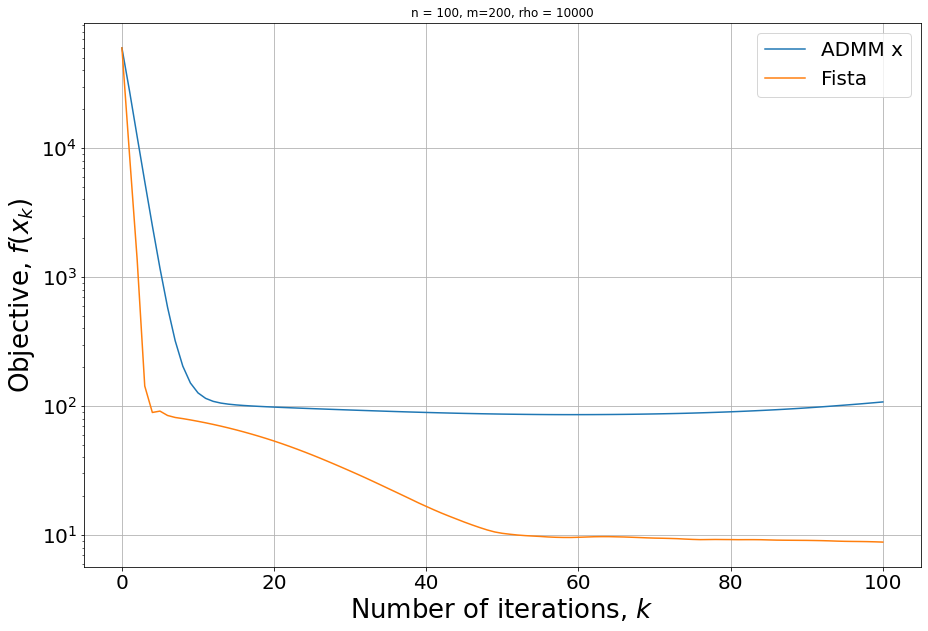

In [18]:
plt.figure(figsize=(15, 10))
plt.semilogy([f(x) for x in conv_x_admm], label="ADMM x")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.semilogy([f_(x)+lam * np.linalg.norm(x, 1) for x in conv_acc], label = 'Fista')
plt.legend(fontsize=20)
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Objective, $f(x_k)$", fontsize=26)
plt.grid(True)
plt.title('n = 100, m=200, rho = 10000')
plt.show()

In [42]:
ns = np.arange(1,400,5)

In [43]:
def admm_fista_timed(ns):
    admm_times = []
    admm_res = []
    fista_times = []
    fista_res = []
    for i in ns:
        
        m = int(i//0.6)
        A = np.random.rand(m,i)
        b = np.random.rand(m)
        x0 = np.random.rand(i)
        z0 = np.random.rand(i)
        mu0 = np.zeros(i)
        
        #true value with cvxpy
        x = cp.Variable(i)
        f = 0.5 * cp.sum_squares(A @ x - b) + lam * cp.norm(x, 1)
        cp.Problem(cp.Minimize(f)).solve(solver=cp.SCS)
        x_cp = x.value
        
        #admm
        f = lambda: 0.5*np.linalg.norm(A@x-b)**2 + lam*np.linalg.norm(x, 1)
        start = pd.Timestamp.now()
        x, _ = admm(update_x_admm, update_z_admm,A,b, rho, x0, z0, mu0, 100, lam, f, tol=1e-6)
        end = pd.Timestamp.now()
        admm_times.append(end-start)
        admm_res.append(np.linalg.norm(x - x_cp))
        
        #fista
        f_ = lambda x: np.linalg.norm(A.dot(x) - b)**2 / 2
        f_grad = lambda x: A.T.dot(A.dot(x) - b)
        f_subgrad = lambda x: A.T.dot(A.dot(x) - b) + gamma * np.sign(x)
        gamma_max = np.linalg.norm(A.T.dot(b), ord=np.inf)
        gamma = 0.1 * gamma_max
        start = pd.Timestamp.now()
        x, _ = prox_alg(f_, f_grad, g_prox, x0, num_iter=100, fix_lam=None, accel=True)
        fista_res.append(np.linalg.norm(x - x_cp))
        end = pd.Timestamp.now()
        fista_times.append(end-start)
        
    return admm_times, admm_res,fista_times, fista_res

In [44]:
admm_time, admm_res,fista_time, fista_res = admm_fista_timed(ns)

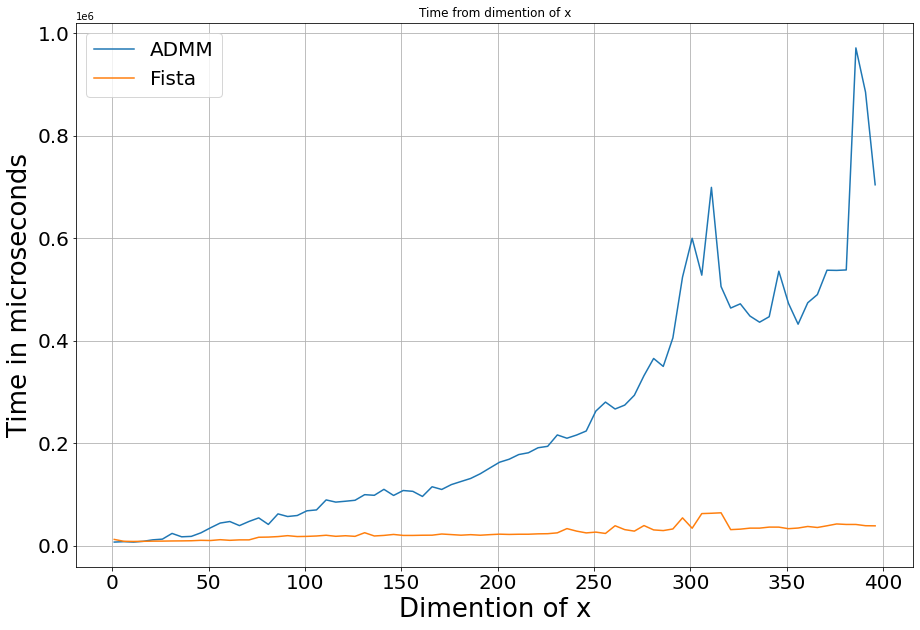

In [45]:
plt.figure(figsize=(15, 10))
plt.plot(ns,[t.microseconds for t in admm_time], label="ADMM")
plt.plot(ns,[t.microseconds for t in fista_time], label="Fista")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.xlabel(r"Dimention of x", fontsize=26)
plt.ylabel(r"Time in microseconds", fontsize=26)
plt.grid(True)
plt.title('Time from dimention of x')
plt.show()

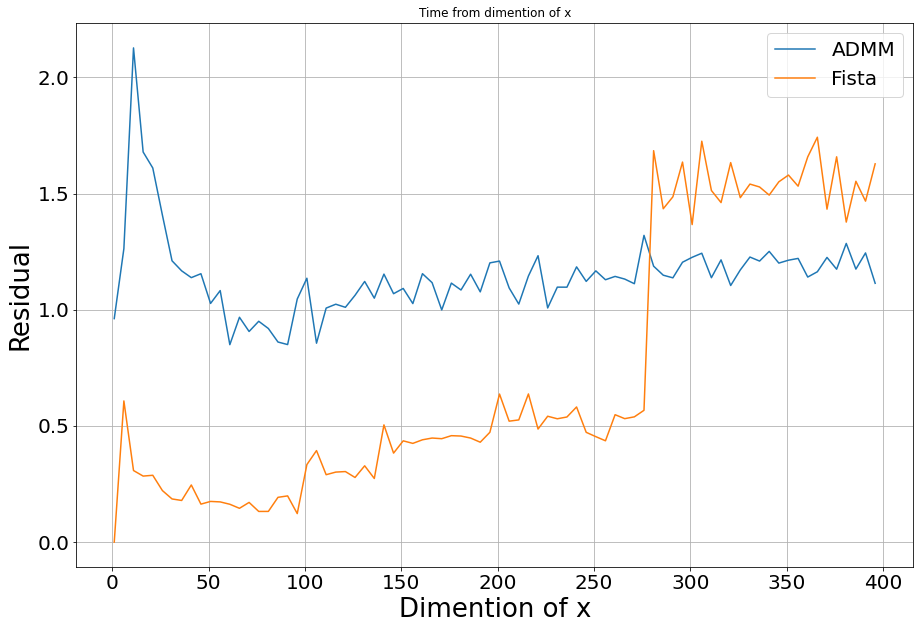

In [46]:
plt.figure(figsize=(15, 10))
plt.plot(ns,[res for res in admm_res], label="ADMM")
plt.plot(ns,[res for res in fista_res], label="Fista")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.xlabel(r"Dimention of x", fontsize=26)
plt.ylabel(r"Residual", fontsize=26)
plt.grid(True)
plt.title('Time from dimention of x')
plt.show()

## Задача 2 (14 pts)

- Для следующей задачи 

\begin{align*}
& \min_{L, S} \|L\|_* + \lambda \|S\|_1\\
\text{s.t. } & L + S = A,
\end{align*}

где $\lambda > 0$ и матрица $A$ - фиксированные параметры, $\|X\|_* = \sum_{i=1}^n \sigma_i(X)$ - сумма сингулярных чисел матрицы $X$, а $\|X\|_1 = \sum_{i=1}^n\sum_{j=1}^m |x_{ij}|$ - сумма модулей элементов матрицы

    - (2 pts) получите форму пригодную для ADMM
    - (3 pts) покажите, как будет выглядеть одна итерация
    - (6 pts) решите вспомогательные задачи минимизации (или опишите каким образом можно получить их решение, не используя итерационные методы оптимизации)

Такая задача нужна для получения представления данной матрицы как суммы малорангового слагаемого $L$ и разреженного слагаемого $S$ и называется Robust PCA.

- (3 pts) Сгенерируйте случайную матрицу размера $100 \times 100$ из малоранговой и разреженной. Примените к ней метод ADMM для решения вышепоставленной задачи. Постройте график сходимости по целеваой функции, а также как изменялся ранг $L_k$ и количество ненулевых элементов в $S_k$. Сравните получившиеся слагаемые с исходными. Как зависит сходимость от параметра $\rho$? Сравните точность и время работы метода ADMM с точностью и временем работы CVXPY. 

При выполнении этого задания я пользовалась результатами [этой](http://www.optimization-online.org/DB_FILE/2009/11/2447.pdf) и вот [этой](https://arxiv.org/pdf/0810.3286.pdf) статей.

Данная задача может быть переформулирована следующим образом: необходимо найти такие матрицы $L$ и $S$, что $L+S = M$ и $L$ -  малоранговая, а $S$ -  разреженная. 

Запишем модифицированную функцию Лагранжа для данной задачи:

$$F_{\mu} (L,S, \Lambda) = \|L\|_* + \lambda \|S\|_1\\ + \langle \Lambda, L+S-M \rangle + \frac{\mu}{2}\|L+S-M\|_F^2 $$

$\begin{equation*}
 \begin{cases}
   S^{k+1} = \arg\min_S F_{\mu}(S, L^k, \Lambda^k),\\
   L^{k+1} = \arg\min_L F_{\mu}(S^{k+1}, L , \Lambda^k),\\
   \Lambda^{k+1} = \Lambda^k + \mu(S^{k+1}+L^{k+1} -M).
 \end{cases}
\end{equation*}$

$\partial F_{\mu_S} = \lambda \partial(\|S\|_1) + \Lambda + \mu (L+S-M) \Rightarrow \lambda(\partial{\|S^{k+1}\|_1)} = -\Lambda^k - \mu (L^k+S^{k+1}-M)$

$S_{i,j}^{k+1} = \begin{equation*}
 \begin{cases}
   (-\frac{1}{\mu} \Lambda^k+M-L^k)_{i,j}-\frac{\lambda}{\mu},& (-\frac{1}{\mu} \Lambda^k+M-L^k - \frac{\lambda}{\mu})_{i,j} >  \frac{\lambda}{\mu},\\
   (-\frac{1}{\mu} \Lambda^k+M-L^k)_{i,j}+\frac{\lambda}{\mu},& (-\frac{1}{\mu} \Lambda^k+M-L^k)_{i,j} < -\frac{\lambda}{\mu},\\
   0,& (-\frac{\lambda}{\mu}< -\frac{1}{\mu} \Lambda^k+M-L^k)_{i,j} <  \frac{\lambda}{\mu}.
 \end{cases}
\end{equation*}$. 

$\partial F_{\mu_L} = \partial(\|L\|_*) + \Lambda + \mu (L+S-M) \Rightarrow (\partial{\|L^{k+1}\|_*)} = -\Lambda^k - \mu (L^{k+1}+S^{k+1}-M)$. 

Определим следующий оператор: (SVT) $\cal{D}_{\tau}(\mathbf{X}) = \arg \min_{\mathbf{Y}}(\|\mathbf{Y}-\mathbf{X}\|_2^2 + \tau \|\mathbf{Y}\|_*).$

В выше указанной статье доказано, что справедливо следующее: $\cal{D}_{\tau}(\mathbf{X}) = \mathbf{U}\cal{D}_{\tau}(\mathbf{\Sigma})\mathbf{V}^*, \cal{D}_{\tau}(\mathbf{\Sigma}) = diag\{\max(\sigma_i - \tau)\}$

Тогда выражение для матрицы $L$ переписывается в следующем виде: 

$L^{k+1} = U^{k+1}diag(\max(\sigma_i, 0))(V^{k+1})^*$

Преобразование $\Lambda$ не меняется:
$\Lambda^{k+1} = \Lambda^k + \mu(S^{k+1}+L^{k+1} -M).$

In [449]:
n,m = 100, 100
S_true = scipy.sparse.rand(m,n, density=0.1)
U_true = ortho_group.rvs(m)
V_true = ortho_group.rvs(n)
d = scipy.sparse.rand(1, m, density=0.1)
d = np.array(d.toarray())
D_true = np.diag(d[0])
L_true = U_true @ D_true @ V_true.T
M = L_true+S_true

In [450]:
np.linalg.matrix_rank(L_true)

10

In [476]:
l = 0.1

S = cp.Variable((m,n))
L = cp.Variable((m,n))

objective = cp.Minimize(l*cp.atoms.norm1(S)+cp.atoms.norm_nuc.normNuc(L))

constraints = [S+L == M]
prob = cp.Problem(objective, constraints)
result = prob.solve(verbose = True)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 100100
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 50100, constraints m = 60100
Cones:	primal zero / dual free vars: 20000
	linear vars: 20000
	sd vars: 20100, sd blks: 1
Setup time: 4.48e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.98e+21  2.46e+21  1.00e+00 -2.65e+23  2.09e+23  1.25e+23  2.86e-02 
   100| 4.80e-04  5.81e-04  1.74e-04  5.19e+01  5.19e+01  2.37e-15  2.54e+00 
   200| 6.49e-05  8.25e-05  1.20e-05  5.19e+01  5.19

In [477]:
M_predict = S.value + L.value

In [478]:
np.linalg.norm(M-M_predict, ord = 'fro')

0.0006091708492528653

In [479]:
method=rpca.RobustPCA(M, lmbda = 0.1)

In [480]:
res = method.solve()

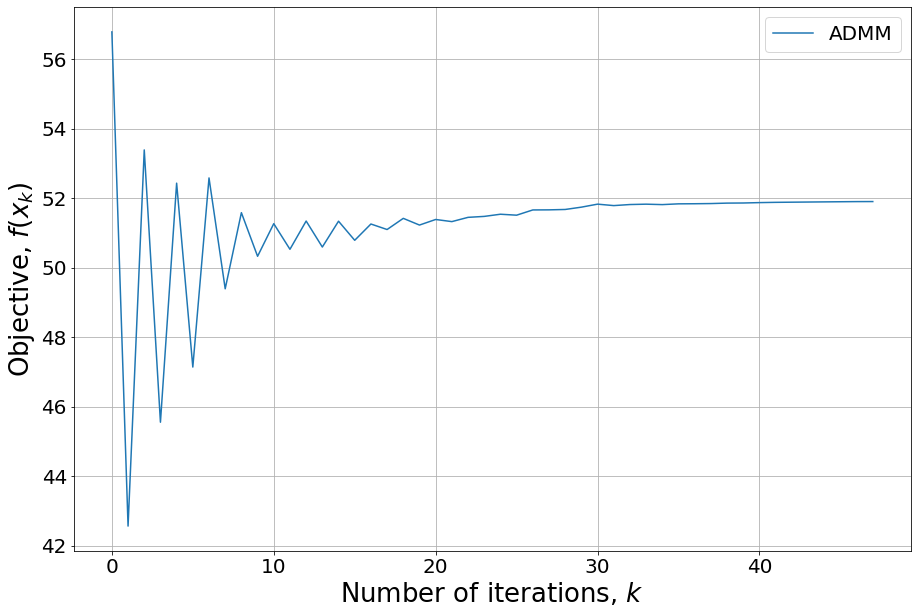

In [481]:
plt.figure(figsize=(15, 10))
plt.plot(method.getitstat()[1], label = 'ADMM')
plt.legend(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Objective, $f(x_k)$", fontsize=26)
plt.grid(True)

In [482]:
print('final rang L:{}, true rang L:{}'.format(np.linalg.matrix_rank(res[0]),np.linalg.matrix_rank(L_true)))

final rang L:10, true rang L:10


In [483]:
print("Number of nonzeros in S = {}, Number of nonzeros in S_true = {} ".format(np.sum(res[1] != 0),S_true.count_nonzero() ) )

Number of nonzeros in S = 1171, Number of nonzeros in S_true = 1000 


In [484]:
M_admm = res[1]+res[0]

In [491]:
np.linalg.norm(M_admm-M, ord='fro')

0.016604958973718314

In [496]:
print("ADMM:")
%timeit method.solve()
print("cvxpy:")
%timeit prob.solve()

ADMM:
2.42 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
cvxpy:
142 ms ± 923 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Получается, что `ADMM` и метод в `cvxpy` по функции сходятся приблизительно к одному значению, но ошибка первого метода сильно больше, но `cvxpy` работает сильно дольше.